 **Lab 5 & 6: Implementing and benchmarking logistic regression classifier for Edge AI**

Interdisciplinary Space Master (ISM) Interdisciplinary Centre for Security, Reliability and Trust

Computer Vision, Imaging, and Machine Intelligence (CVI2) group

Course Responsible: Prof. Djamila Aouada (djamila.aouada@uni.lu)

TAs: Dr. Leo Pauly (leo.pauly@uni.lu), Dr. Nilotpal Sinha (nilotpal.sinha@uni.lu)

7 December 2022


**Task A: Training in the Cloud**
 
1. Implement and train a binary classifier using logistic regression algorithm in Google Colab. 
2. Record accuracy and inference time required on the test dataset

**Task B: Deploying at Edge**

1. Deploy the pre-trained classifier in the Raspberry Pi board.
2. Record accuracy and inference time required for the test dataset

**Additional reference**

Logistic regression: https://en.wikipedia.org/wiki/Logistic_regression


In [ ]:
import numpy as np
import PIL 
import os

In [ ]:
## For reading files from Google drive.
## Note that the path has to be changed when implementing the same on the Raspberry Pi board
from google.colab import drive
drive.mount('/content/drive')
base_dir='/content/drive/My Drive/CVIA_labs_5_6_data/'

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt

## Function for reading images from a folder, resizing images (to the height and width specified) and converting into np arrays
def load_images_from_folder(folder,width,height):
    images = []
    filenames=sorted(os.listdir(folder))
    print(filenames)
    for filename in filenames:
        # Reading image from the folder
        img = PIL.Image.open(folder+filename)
        # Convert to RGB to remove Alpha channel
        img = img.convert('RGB')
        # Resize and convert to Numpy array
        img = np.array(img.resize((width,height)))
        images.append(img)
    return np.array(images)

## Check if the images and class labels are loaded correctly
def check_image_label(index, images, classes):
      print("\n\ny = " + str(classes[index]))
      img = images[index]
      print('maxval: {}\nminval: {}'.format(img.max(), img.min()))
      plt.imshow(img)
      plt.show()

**Instructions**
1. Use load_images_from_folder() for reading images from the stored /train folders.
2. Create class labels (0: Non-Satellite, 1: Satellite class) using functions np.zeros() and np.ones() and np.append(). 



['00.png', '01.png', '02.png', '03.png', '04.png', '05.png', '06.png', '07.png', '08.png', '09.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png']


y = 1.0
maxval: 243
minval: 0


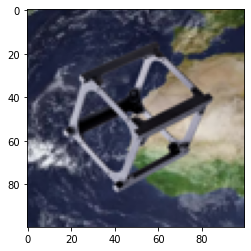



y = 0.0
maxval: 174
minval: 0


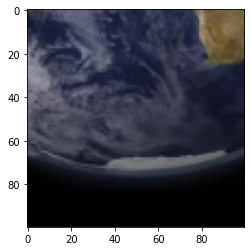

In [ ]:
width = 100
height = 100
# Use load_images_from_folder() to read all the stored training images
# Training images loaded as an numpy array:
train_path = base_dir + "train/"
train_images = load_images_from_folder(train_path, width, height)

# The train/test split is 80/20.
# 0.8 * 30 = 24, so there are 24 training images.
# The first half (12) of these are satellite, and the second half (12) are not.
satellite = np.ones(12)
non_satellite = np.zeros(12)
# Create a single concatenated class labels array
cls_train = np.concatenate((satellite, non_satellite))

## Check if the images and class labels are loaded correctly
check_image_label(0,  train_images, cls_train)
check_image_label(15, train_images, cls_train)

**Instructions**
3. Reshape images of size (H,W,3) into (HxWx3,1) and stack them together into a matrix of size (HxWx3,N) where each column is a flattened image. 

  Hint: Image_array = Image_array.reshape(Image_array.shape[0], -1).T  



In [ ]:
## Flatten and stack images into a matrix
train_images_flatten = train_images.reshape(train_images.shape[0], -1).T

## Print all resultant sizes. Check if all matrix dimensions match 
print('No: of training images:',train_images.shape)
print('Size of class labels:',cls_train.shape)
print('Size of training image matrix:',train_images_flatten.shape)
print('maxval: {}\nminval: {}'.format(train_images_flatten.max(), train_images_flatten.min()))

No: of training images: (24, 100, 100, 3)
Size of class labels: (24,)
Size of training image matrix: (30000, 24)
maxval: 247
minval: 0


**Instructions**
4. Normalise image pixel values to range [0,1] 

In [ ]:
### Test image normalization on one image
### using 255 as the dividend to convert from [0,255] to [0,1]
# print("RGB values for first image:", train_images[0][2])
# print("Normalized RGB values for first image:", train_images[0][2] / 255)

def normalize_data(flattened_images):
  # Explicitly cast as Float64
  flattened_images = flattened_images.astype(np.float64)
  # Divide by 255 to normalize
  flattened_images /= np.float64(255)
  return flattened_images

# Apply normalization
train_images_flatten = normalize_data(train_images_flatten)
# Check that normalization worked
print('Size of training image matrix:',train_images_flatten.shape)
print('maxval: {}\nminval: {}'.format(train_images_flatten.max(), train_images_flatten.min()))

Size of training image matrix: (30000, 24)
maxval: 0.9686274509803922
minval: 0.0


**Instructions**
5. Implement sigmoid function sigmoid(z).

  $sigmoid(z) = \frac{1}{1 + e^{-(z)}}$

In [ ]:
def sigmoid(z):
    # Sigmoid function implementation
    return 1.0 / (1.0 + np.exp(-z))

**Instructions**
6. Implement forward and backward pass inside the function propagate() 

 Forward Propagation:

- $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

 Calculating gradients:

- $ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$
- $ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$

In [ ]:
def calculate_J(m, Y, A):
    terms = []
    # Calculate and store all the terms
    for i in range(0, m-1):
      y = Y[i]
      a = A[i]
      term = y * np.log(a) + (1 - y) * np.log(1 - a)
      # Store the term for summation later
      terms.append(term)
    # Convert to Numpy array
    terms = np.array(terms)
    # Multiply scalar by sum of terms
    J = (-1/m) * terms.sum()
    return J

def forward_prop(m, w, b, X, Y):
    ## Forward propagation
    z = np.matmul(w.T, X) + b
    A = sigmoid(z).flatten()
    # print('A:', A.shape)
    # print('Y:', Y.shape)
    # Calculate J
    cost = calculate_J(m, Y, A)
    return A, cost

def back_prop(m, X, Y, A):
    ## Backward propagation: calculate gradients dw and db
    dw = (1/m) * np.matmul(X, ((A - Y).T))
    db = (1/m) * (A - Y).sum()
    return dw, db

## Function for forward and backward propagation of the values
def propagate(w, b, X, Y):
    m = X.shape[1]
    # print("m:", m)
    ## Forward propagation
    A, cost = forward_prop(m, w, b, X, Y)
    ## Backward propagation
    dw, db = back_prop(m, X, Y, A)
    # Return gradients and cost
    return dw,db, cost

**Instructions**
7. Update weights using the update rules given below. 

 Update rule:

 $ w = w - \alpha \text{ } dw$
 
 $ b = b - \alpha \text{ } db$

 $\alpha$ = learning rate

In [ ]:
## Define and initialise weights and bias with zero values
dim = train_images_flatten.shape[0]
w = np.zeros((dim,1))
b = 0
print('Size of the weight vector initialised:', w.shape)
print('Size of the bias initialised:', np.shape(b))

## Training the classifier 
costs = []
num_iterations = 500
learning_rate = 0.001
a = learning_rate
for i in range(num_iterations):
  # print('w:', w.shape)
  # print('b:', b)
  dw,db, cost = propagate(w, b, train_images_flatten, cls_train)
  # Reshape `dw` to match `w`
  dw = dw.reshape((dw.shape[0], 1))
  ## Update weights 
  w = w - (a * dw)
  b = b - (a * db)
  # print('dw:', dw.shape)
  # print('db:', db)
  # print('post-update, w:', w.shape)
  # print('post-update, b:', b)
  costs.append(cost)
  print('Loss at iteration',i,':',round(cost,2)) 

Size of the weight vector initialised: (30000, 1)
Size of the bias initialised: ()
Loss at iteration 0 : 0.66
Loss at iteration 1 : 0.66
Loss at iteration 2 : 0.65
Loss at iteration 3 : 0.64
Loss at iteration 4 : 0.63
Loss at iteration 5 : 0.63
Loss at iteration 6 : 0.62
Loss at iteration 7 : 0.61
Loss at iteration 8 : 0.61
Loss at iteration 9 : 0.6
Loss at iteration 10 : 0.59
Loss at iteration 11 : 0.59
Loss at iteration 12 : 0.58
Loss at iteration 13 : 0.58
Loss at iteration 14 : 0.57
Loss at iteration 15 : 0.57
Loss at iteration 16 : 0.56
Loss at iteration 17 : 0.56
Loss at iteration 18 : 0.55
Loss at iteration 19 : 0.55
Loss at iteration 20 : 0.54
Loss at iteration 21 : 0.54
Loss at iteration 22 : 0.53
Loss at iteration 23 : 0.53
Loss at iteration 24 : 0.52
Loss at iteration 25 : 0.52
Loss at iteration 26 : 0.52
Loss at iteration 27 : 0.51
Loss at iteration 28 : 0.51
Loss at iteration 29 : 0.5
Loss at iteration 30 : 0.5
Loss at iteration 31 : 0.5
Loss at iteration 32 : 0.49
Loss at

**Instructions**
8. Similarly load test images from the stored folder and calculate accuracy of the learned classifier on the test dataset. Note that you need to convert output from the classifier in the form of logits to binary outputs using a thresholding function. 
9. Benchmark inference time required for testing images. 
10. Store the learned parameters into a .txt file using np.savetxt() for deploying at the edge device.


['24.png', '25.png', '26.png', '27.png', '28.png', '29.png']


y = 1.0
maxval: 247
minval: 0


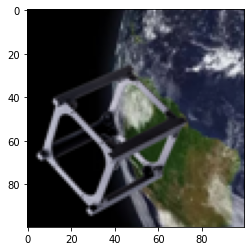



y = 0.0
maxval: 204
minval: 0


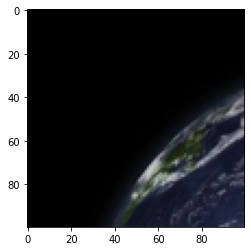

In [ ]:
width = 100
height = 100
# Use load_images_from_folder() to read all the stored test images
# Test images loaded as an numpy array:
test_path = base_dir + "test/"
test_images = load_images_from_folder(test_path, width, height)

# The train/test split is 80/20.
# 0.2 * 30 = 6, so there are 6 testing images.
# The first half (3) of these are satellite, and the second half (3) are not.
satellite = np.ones(3)
non_satellite = np.zeros(3)
# Create a single concatenated class labels array
cls_test = np.concatenate((satellite, non_satellite))

## Check if the images and class labels are loaded correctly
check_image_label(0, test_images, cls_test)
check_image_label(5, test_images, cls_test)

In [ ]:
## Flatten and stack images into a matrix
test_images_flatten = test_images.reshape(test_images.shape[0], -1).T
## Print all resultant sizes. Check if all matrix dimensions match 
print('No: of TEST images:',test_images.shape)
print('Size of TEST class labels:',cls_test.shape)
print('Size of TEST image matrix:',test_images_flatten.shape)
print('maxval: {}\nminval: {}'.format(test_images_flatten.max(), test_images_flatten.min()))
## Apply normalization
test_images_flatten = normalize_data(test_images_flatten)
# Check that normalization worked
print('Size of TEST image matrix:',test_images_flatten.shape)
print('maxval: {}\nminval: {}'.format(test_images_flatten.max(), test_images_flatten.min()))

No: of TEST images: (6, 100, 100, 3)
Size of TEST class labels: (6,)
Size of TEST image matrix: (30000, 6)
maxval: 247
minval: 0
Size of TEST image matrix: (30000, 6)
maxval: 0.9686274509803922
minval: 0.0


In [ ]:
from datetime import datetime
# Calculate accuracy of the learned classifier on the test dataset.
# Convert output from the classifier in the form of logits to binary outputs using a thresholding function.
# Benchmark inference time required for testing images.

def threshold(A):
    # Manual threshold implementation
    # though could also use `np.round()`
    A[A >= 0.5] = 1
    A[A < 0.5] = 0
    return A

def test_classifier(w, b, X, Y):
    m = X.shape[1]
    # print("m:", m)
    A, cost = forward_prop(m, w, b, X, Y)
    predictions = threshold(A)
    print("Test Results:")
    print("\tCost:\t\t\t", cost)
    print("\tPredictions:\t\t", predictions)
    print("\tGround Truth:\t\t", Y)
    correct = (predictions == Y).sum()
    print("\tTest Accuracy:\t\t {}/{} ({:.0f}%)".format(correct, m, (correct/m) * 100))

# Capture the time before testing
start = datetime.now()
# Test the trained classifier
test_classifier(w, b, test_images_flatten, cls_test)
# Capture the time after testing
end = datetime.now()
# Calculate time delta for testing period
elapsed = end - start
print("\nTime required for testing images:", elapsed)

Test Results:
	Cost:			 0.7211294472886607
	Predictions:		 [1. 0. 0. 1. 1. 1.]
	Ground Truth:		 [1. 1. 1. 0. 0. 0.]
	Test Accuracy:		 1/6 (17%)

Time required for testing images: 0:00:00.005137


In [ ]:
# Store the learned parameters into a .txt file using np.savetxt() for deploying at the edge device.
np.savetxt("learned_weights.txt", w)
np.savetxt("learned_bias.txt", np.array([b]))

**Instructions** 
11. Copy the saved parameters and required code into the Raspberry Pi board. 
12. Deploy the pre-trained classifier. Calculate results with accuracy and benchmark inference time on the test dataset. 
13. Optional: Collect an image using Pi camera and perform classification using the deployed classifier.